In [1]:
from aiohttp import ClientSession
from influxdb_client.client.influxdb_client_async import InfluxDBClientAsync
import asyncio
from tqdm import tqdm
from datetime import datetime, timedelta, timezone
import pandas as pd
from binance import AsyncClient
from binance.exceptions import BinanceAPIException

import dataclasses


__COINS = {
    'btc': 'bitcoin',  # 2020
    'eth': 'ethereum',  # 2020
    'xrp': 'ripple',  # 2020
    'sol': 'solana',  # 2021
    # 'doge': 'dogecoin', # 2021
    'ltc': 'litecoin',  # 2020
    'ada': 'cardano',  # 2020
}

@dataclasses.dataclass
class Coin:
    BTC: str = 'btc'  # 2020
    ETH: str = 'eth'  # 2020
    XRP: str = 'xrp'  # 2020
    SOL: str = 'sol'  # 2021
    # 'doge = 'doge' # 2021
    LTC: str = 'ltc'  # 2020
    ADA: str = 'ada'  # 2020


coin = Coin()


In [52]:
# predicate = f'_measurement="{KLINES_MEASUREMENT}"'
# # # TO DELETE ALL ROWS.
#
# async with InfluxDBClientAsync(url=INFLUXDB_URL, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG) as influxdb_client:
#     delete_api = influxdb_client.delete_api()
#     await delete_api.delete(bucket=INFLUXDB_BUCKET, start=start - timedelta(minutes=1000), stop = end + timedelta(1000), predicate=predicate)


In [62]:
query_api = client.query_api()

FUTURES_BUCKET = 'FUTURES'
KLINES_MEASUREMENT = 'klines'
start = datetime(year=2021, month=1, day=1)

range_string = f" |> range(start: {int(start.timestamp())}) "

query = f'''
    from(bucket: "{FUTURES_BUCKET}")''' + range_string + f'''
      |> filter(fn: (r) => r["_measurement"] == "{KLINES_MEASUREMENT}")
      |> aggregateWindow(every: 1h, fn: mean, createEmpty: false)
      |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''
output = query_api.query_data_frame(query)
output["coin"] = output["pair"].str.replace('usdt', '')


In [103]:
import dataclasses


@dataclasses.dataclass
class FieldData:
    close: pd.DataFrame
    open: pd.DataFrame
    high: pd.DataFrame
    low: pd.DataFrame
    volume: pd.DataFrame
    quote_asset_volume: pd.DataFrame
    number_of_trades: pd.DataFrame
    taker_buy_base_asset_volume: pd.DataFrame
    taker_buy_quote_asset_volume: pd.DataFrame

    @classmethod
    @property
    def fields(cls) -> list[str]:
        return [field.name for field in dataclasses.fields(FieldData)]

    @classmethod
    def create(cls, raw_data) -> 'FieldData':
        # prices = output[['close', 'pair', '_time']]
        data = {}

        for field in cls.fields:
            data_field = raw_data[[field, 'coin', '_time']]
            data_field.index = data_field['_time']
            data_field = data_field.pivot(index='_time', columns='coin', values=field)
            data[field] = data_field
        return cls(**data)


@dataclasses.dataclass
class PairData:
    BTC: pd.DataFrame
    ETH: pd.DataFrame
    XRP: pd.DataFrame
    SOL: pd.DataFrame
    LTC: pd.DataFrame
    ADA: pd.DataFrame

    @classmethod
    def create(cls, raw_data) -> 'PairData':
        data = {}

        for key, value in dataclasses.asdict(coin).items():
            data_pair = raw_data[raw_data['coin'] == value]
            data_pair.index = data_pair['_time']
            data[key] = data_pair[FieldData.fields]

        return cls(**data)

In [104]:
pair_data = PairData.create(output)
field_data = FieldData.create(output)

In [219]:
import numpy as np

def fisher_transform(r):
    return 0.5 * np.log((1 + r) / (1 - r))

def inverse_fisher_transform(z):
    return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)

WINDOW = 24 * 7
df = np.log1p(field_data.close.pct_change()).rolling(WINDOW,  min_periods=WINDOW).corr()
df_reset = df.reset_index()
df_melt = df_reset.melt(id_vars=['_time', 'coin'], var_name='coin_pair', value_name='price')
df_pivot = df_melt.pivot(index='_time', columns=['coin', 'coin_pair'], values='price')



# columns = list(set(tuple(sorted(column)) for column in df_pivot.columns if (column[0] != column[1])))
columns = list(column for column in df_pivot.columns if (column[0] != column[1]))
df_pivot = df_pivot[columns]
df_pivot = df_pivot.iloc[WINDOW:]

df_save = df_melt[(df_melt['coin'] != df_melt['coin_pair']) & (~pd.isna(df_melt['price']))]
# df_save = df_melt[(~pd.isna(df_melt['correlation']))]
df_save = df_save.set_index('_time')
write_api = client.write_api()

write_api.write(
    bucket=STATISTICS_BUCKET,
    record=df_save,
    data_frame_measurement_name=MEASUREMENT,
    data_frame_tag_columns=['coin', 'coin_pair']
)

,coin,coin_pair,price
_time,,,
2021-01-07 22:00:00+00:00,btc,ada,0.427549
2021-01-07 22:00:00+00:00,eth,ada,0.585612
2021-01-07 22:00:00+00:00,ltc,ada,0.665119
2021-01-07 22:00:00+00:00,sol,ada,0.330721
2021-01-07 22:00:00+00:00,xrp,ada,0.208616
...,...,...,...
2023-07-23 00:00:00+00:00,ada,xrp,0.710948
2023-07-23 00:00:00+00:00,btc,xrp,0.414640
2023-07-23 00:00:00+00:00,eth,xrp,0.479869


In [221]:
import numpy as np

skip_rows = 24 * 5
df = (field_data.quote_asset_volume.pct_change()).rolling('7d', min_periods=skip_rows ).corr()
df_reset = df.reset_index()
df_melt = df_reset.melt(id_vars=['_time', 'coin'], var_name='coin_pair', value_name='volume')
df_pivot = df_melt.pivot(index='_time', columns=['coin', 'coin_pair'], values='volume')



# columns = list(set(tuple(sorted(column)) for column in df_pivot.columns if (column[0] != column[1])))
columns = list(column for column in df_pivot.columns if (column[0] != column[1]))
df_pivot = df_pivot[columns]
df_pivot = df_pivot.iloc[skip_rows:]

df_save = df_melt[(df_melt['coin'] != df_melt['coin_pair']) & (~pd.isna(df_melt['volume']))]
# df_save = df_melt[(~pd.isna(df_melt['correlation']))]
df_save = df_save.set_index('_time')
df_save

,coin,coin_pair,volume
_time,,,
2021-01-05 22:00:00+00:00,btc,ada,0.608978
2021-01-05 22:00:00+00:00,eth,ada,0.651184
2021-01-05 22:00:00+00:00,ltc,ada,0.683238
2021-01-05 22:00:00+00:00,sol,ada,0.384375
2021-01-05 22:00:00+00:00,xrp,ada,0.349031
...,...,...,...
2023-07-23 00:00:00+00:00,ada,xrp,0.581175
2023-07-23 00:00:00+00:00,btc,xrp,0.325829
2023-07-23 00:00:00+00:00,eth,xrp,0.410273


In [222]:
STATISTICS_BUCKET = "STATISTICS"
MEASUREMENT = "correlation_week"

write_api = client.write_api()

write_api.write(
    bucket=STATISTICS_BUCKET,
    record=df_save,
    data_frame_measurement_name=MEASUREMENT,
    data_frame_tag_columns=['coin', 'coin_pair']
)

In [6]:
data

{'timezone': 'UTC',
 'serverTime': 1690230051974,
 'rateLimits': [{'rateLimitType': 'REQUEST_WEIGHT',
   'interval': 'MINUTE',
   'intervalNum': 1,
   'limit': 1200},
  {'rateLimitType': 'ORDERS',
   'interval': 'SECOND',
   'intervalNum': 10,
   'limit': 50},
  {'rateLimitType': 'ORDERS',
   'interval': 'DAY',
   'intervalNum': 1,
   'limit': 160000},
  {'rateLimitType': 'RAW_REQUESTS',
   'interval': 'MINUTE',
   'intervalNum': 5,
   'limit': 6100}],
 'exchangeFilters': [],
 'symbols': [{'symbol': 'ETHBTC',
   'status': 'TRADING',
   'baseAsset': 'ETH',
   'baseAssetPrecision': 8,
   'quoteAsset': 'BTC',
   'quotePrecision': 8,
   'quoteAssetPrecision': 8,
   'baseCommissionPrecision': 8,
   'quoteCommissionPrecision': 8,
   'orderTypes': ['LIMIT',
    'LIMIT_MAKER',
    'MARKET',
    'STOP_LOSS_LIMIT',
    'TAKE_PROFIT_LIMIT'],
   'icebergAllowed': True,
   'ocoAllowed': True,
   'quoteOrderQtyMarketAllowed': False,
   'allowTrailingStop': True,
   'cancelReplaceAllowed': True,
   '

In [224]:
# # buckets_api = client.buckets_api()
# # bucket = buckets_api.find_bucket_by_name(STATISTICS_BUCKET)
# # buckets_api.delete_bucket(bucket)
# # buckets_api.create_bucket(bucket_name=STATISTICS_BUCKET)
#
# predicate = f'_measurement="{MEASUREMENT}" and _field="volume_correlation"'
# # # TO DELETE ALL ROWS.
#
# start = datetime(year=2020, month=1, day=1)
# stop = datetime(year=2024, month=1, day=1)
# delete_api = client.delete_api()
# delete_api.delete(bucket=STATISTICS_BUCKET, start=start, stop=stop,  predicate=predicate)

ApiException: (501)
Reason: Not Implemented
HTTP response headers: HTTPHeaderDict({'Content-Type': 'application/json; charset=utf-8', 'X-Influxdb-Build': 'OSS', 'X-Influxdb-Version': 'v2.7.1', 'X-Platform-Error-Code': 'not implemented', 'Date': 'Sun, 23 Jul 2023 15:52:29 GMT', 'Content-Length': '71'})
HTTP response body: {"code":"not implemented","message":"delete by field is not supported"}


<Axes: xlabel='coin', ylabel='coin'>

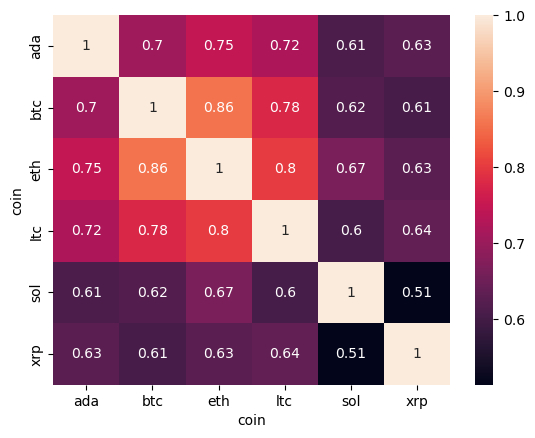

In [274]:
import seaborn as sns
corr_df = np.log1p(field_data.close.pct_change()).corr()

sns.heatmap(corr_df, annot=True)

In [234]:
# (field_data.close.btc / field_data.close.eth).pct_change()
for key, value in dataclasses.asdict(pair_data).items():
    print(key)
    break

BTC


In [329]:
from itertools import combinations_with_replacement

df = field_data.close

rel_data_all = []

MONTH_PERIOD = 24 * 30
for coin1, coin2 in tqdm(list(combinations_with_replacement(df.columns, 2))):

    if coin1 == coin2:
        continue
    rel_data: pd.Series = df[coin1] / df[coin2]
    rel_data = rel_data.to_frame()
    rel_data.columns = ['rel_price']
    rel_data['rel_returns'] = rel_data.pct_change()
    # rel_data['rel_returns'] = rel_data.pct_change()
    # rel_data = rel_data / rel_data.mean()
    rel_data['coin'] = coin1
    rel_data['coin_pair'] = coin2
    rel_data['rel_price_gain_month'] = (
        rel_data['rel_price'] /
        rel_data['rel_price'].rolling(MONTH_PERIOD,  min_periods=MONTH_PERIOD).mean()
    )
    rel_data = rel_data.iloc[1:]
    # # rel_data_all.append(rel_data)
    write_api.write(
        bucket=STATISTICS_BUCKET,
        record=rel_data,
        data_frame_measurement_name=MEASUREMENT,
        data_frame_tag_columns=['coin', 'coin_pair']
    )

100%|██████████| 21/21 [00:04<00:00,  5.12it/s]


In [328]:
rel_data

,rel_price,rel_returns,coin,coin_pair,rel_price_gain
_time,,,,,
2020-12-31 23:00:00+00:00,0.000006,-0.002608,ada,btc,NaN
2021-01-01 00:00:00+00:00,0.000006,0.005383,ada,btc,NaN
2021-01-01 01:00:00+00:00,0.000006,-0.002741,ada,btc,NaN
2021-01-01 02:00:00+00:00,0.000006,-0.000649,ada,btc,NaN
2021-01-01 03:00:00+00:00,0.000006,0.009735,ada,btc,NaN
...,...,...,...,...,...
2023-07-22 20:00:00+00:00,0.000010,-0.000434,ada,btc,1.065386
2023-07-22 21:00:00+00:00,0.000010,0.002850,ada,btc,1.068309
2023-07-22 22:00:00+00:00,0.000010,-0.000307,ada,btc,1.067871


In [ ]:

# rel_data_all
# from(bucket: "STATISTICS")
#   |> range(start: v.timeRangeStart, stop: v.timeRangeStop)
#   |> filter(fn: (r) => r["_measurement"] == "correlation_week")
#   |> filter(fn: (r) => r["_field"] == "rel_price")
#   |> filter(fn: (r) => r["coin"] == "btc")
#   |> filter(fn: (r) => r["coin_pair"] == "eth")
#   |> aggregateWindow(every: v.windowPeriod, fn: mean, createEmpty: false)
#   |> yield(name: "mean")

In [282]:
query_api = client.query_api()


rel_price = query_api.query_data_frame("""
    from(bucket: "STATISTICS")
      |> range(start: 0)
      |> filter(fn: (r) => r["_measurement"] == "correlation_week")
      |> filter(fn: (r) => r["_field"] == "rel_price")
      |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
""")

In [298]:
# rel_price = rel_price.set_index("_time")
rel_price["_time"] = rel_price.index

In [299]:
rel_price.pivot(columns=["coin_pair"], index=["_time", "coin"], values="rel_price")

coin_pair                            btc        eth         ltc           sol  \
_time                     coin                                                  
2020-12-31 23:00:00+00:00 ada   0.000006   0.000244    0.001454      0.119654   
                          btc        NaN  39.307774  234.240965  19276.986098   
                          eth        NaN        NaN    5.959151    490.411537   
                          ltc        NaN        NaN         NaN     82.295537   
                          sol        NaN        NaN         NaN           NaN   
...                                  ...        ...         ...           ...   
2023-07-23 00:00:00+00:00 ada   0.000010   0.000165    0.003359      0.012509   
                          btc        NaN  15.926603  323.464380   1204.432235   
                          eth        NaN        NaN   20.309690     75.623924   
                          ltc        NaN        NaN         NaN      3.723539   
                          sol        NaN        NaN         NaN           NaN   

coin_pair                                 xrp  
_time                     coin                 
2020-12-31 23:00:00+00:00 ada        0.806451  
                          btc   129924.602182  
                          eth     3305.315649  
                          ltc      554.662171  
                          sol        6.739882  
...                                       ...  
2023-07-23 00:00:00+00:00 ada        0.419306  
                          btc    40374.136765  
                          eth     2535.012415  
                          ltc      124.817876  
                          sol       33.521302  

[111970 rows x 5 columns]